## Problem Statement

#### Your client is a Financial Distribution company. Over the last 10 years, they have created an offline distribution channel across country. They sell Financial products to consumers by hiring agents in their network. These agents are freelancers and get commission when they make a product sale.



Overview of your client On-boarding process
The Managers at your client are primarily responsible for recruiting agents. Once a manager has identified a potential applicant, the would explain the business opportunity to the agent. Once the agent provides the consent, an application is made to your client to become an agent. This date is known as application_receipt_date.

In the next 3 months, this potential agent has to undergo a 7 days training at the your client's branch (about Sales processes and various products) and clear a subsequent examination in order to become an agent.




The problem - Who are the best agents?
As is obvious in the above process, there is a significant investment which your cleint makes in identifying, training and recruiting these agents. However, there are a set of agents who do not bring in the expected resultant business.

Your client is looking for help from data scientists like you to help them provide insigths using their past recruitment data. They want to predict the target variable for each potential agent, which would help them identify the right agents to hire.

### Data Ditictionary

In [2]:
#import tensorflow as tf 
import keras
from keras.layers import Dense,Dropout
from keras.models import Sequential
from sklearn.preprocessing import StandardScaler
from keras.models import load_model
from keras.callbacks import ReduceLROnPlateau,ModelCheckpoint
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [4]:
import numpy as np
import pandas as pd 
import os
from sklearn.model_selection import KFold,StratifiedKFold
from lightgbm import LGBMClassifier
import warnings
warnings.filterwarnings('ignore')
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight,compute_sample_weight


In [67]:
path=r'D:/Study/Hackathon analytics vidhya/Hackathon AV hiring  10092020/'
train_df=pd.read_csv(os.path.join(path,'train.csv'))
test_df=pd.read_csv(os.path.join(path,'test.csv'))
submission_df=pd.read_csv(os.path.join(path,'sample.csv'))
combine_set1 =pd.read_csv(os.path.join(path,'combine_data_train_test6.csv'))

In [30]:
combine_set1['Business_Sourced'].value_counts(normalize = True)*100

0.0    65.707988
1.0    34.292012
Name: Business_Sourced, dtype: float64

In [31]:
combine_set1['Business_Sourced'].head

<bound method NDFrame.head of 0        0.0
1        1.0
2        0.0
3        0.0
4        0.0
        ... 
14567    NaN
14568    NaN
14569    NaN
14570    NaN
14571    NaN
Name: Business_Sourced, Length: 14572, dtype: float64>

In [20]:
#Encoding Categorical Columns
le=LabelEncoder()
for col in combine_set1.select_dtypes(include='object').columns:
    if col not in ['Business_Sourced']:
#         fe=combine_set.groupby([col]).size()/len(combine_set)
#         combine_set[col]=combine_set[col].apply(lambda x: fe[x])
        df=pd.get_dummies(combine_set1[col],drop_first=True)
        combine_set1=pd.concat([combine_set1,df],axis=1).drop([col],axis=1)
          
    elif col!='Business_Sourced':
        combine_set[col]=le.fit_transform(combine_set[col].astype(str))
    else:
        pass
        
combine_set1.head(5) 

,Manager_Grade,Manager_Num_Application,Manager_Num_Coded,Manager_num_Product_diff,Manager_Business_Diff,Unnamed: 7,Manager_Actual_Business_ratio,Manager_Num_Coded_ratio,M,M.1,...,"[13, 14[","[14, 15[","[15, 17]","[40, 42[","[42, 44[","[44, 45[","[45, 47[","[47, 49[","[49, 51[","[51, 55]"
0,3,2,1,0,0,NaN,0,-27,1,1,...,0,0,1,0,1,0,0,0,0,0
1,3,2,1,0,0,NaN,0,-27,1,0,...,0,0,1,0,1,0,0,0,0,0
2,2,0,0,0,0,NaN,0,-24,1,1,...,0,1,0,0,0,0,0,0,0,1
3,4,0,0,0,0,NaN,0,-22,1,0,...,0,0,1,0,1,0,0,0,0,0
4,2,2,1,0,0,NaN,0,-16,1,1,...,0,1,0,0,0,0,0,0,1,0


In [28]:
combine_set1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14572 entries, 0 to 14571
Data columns (total 75 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Manager_Grade                            14572 non-null  int64  
 1   Manager_Num_Application                  14572 non-null  int64  
 2   Manager_Num_Coded                        14572 non-null  int64  
 3   Manager_num_Product_diff                 14572 non-null  int64  
 4   Manager_Business_Diff                    14572 non-null  int64  
 5   Unnamed: 7                               0 non-null      float64
 6   Manager_Actual_Business_ratio            14572 non-null  int64  
 7   Manager_Num_Coded_ratio                  14572 non-null  int64  
 8   M                                        14572 non-null  int64  
 9   M.1                                      14572 non-null  int64  
 10  S                                        14572

In [54]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
X=combine_set1[combine_set1['Business_Sourced'].isnull()==False].drop(['Business_Sourced'],axis=1)
y=le.fit_transform(combine_set1[combine_set1['Business_Sourced'].isnull()==False]['Business_Sourced'])
y=pd.DataFrame(y,columns=['Business_Sourced'])
X_main_test=combine_set1[combine_set1['Business_Sourced'].isnull()==True].drop(['Business_Sourced'],axis=1)
X = X.drop(['Unnamed: 7'],axis= 1)
X_main_test = X_main_test.drop(['Unnamed: 7'],axis= 1)


In [50]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9527 entries, 0 to 9526
Data columns (total 73 columns):
 #   Column                                   Non-Null Count  Dtype
---  ------                                   --------------  -----
 0   Manager_Grade                            9527 non-null   int64
 1   Manager_Num_Application                  9527 non-null   int64
 2   Manager_Num_Coded                        9527 non-null   int64
 3   Manager_num_Product_diff                 9527 non-null   int64
 4   Manager_Business_Diff                    9527 non-null   int64
 5   Manager_Actual_Business_ratio            9527 non-null   int64
 6   Manager_Num_Coded_ratio                  9527 non-null   int64
 7   M                                        9527 non-null   int64
 8   M.1                                      9527 non-null   int64
 9   S                                        9527 non-null   int64
 10  W                                        9527 non-null   int64
 11  Miss

In [22]:
y_hat=to_categorical(y)
y_hat=pd.DataFrame(y_hat)
sc_X=StandardScaler()
X=sc_X.fit_transform(X)
X=pd.DataFrame(X)
sc_X_main=StandardScaler()
X_main_test=sc_X_main.fit_transform(X_main_test)
X.head(5)

,0,1,2,3,4,5,6,7,8,9,...,63,64,65,66,67,68,69,70,71,72
0,-0.223319,0.027002,0.254327,-0.051032,-0.056884,-0.056884,-2.577037,0.561065,0.724099,-0.722416,...,-0.725616,-0.522477,1.649252,-0.29966,2.903907,-0.25531,-0.398751,-0.342645,-0.302150,-0.597759
1,-0.223319,0.027002,0.254327,-0.051032,-0.056884,-0.056884,-2.577037,0.561065,-1.381026,1.384244,...,-0.725616,-0.522477,1.649252,-0.29966,2.903907,-0.25531,-0.398751,-0.342645,-0.302150,-0.597759
2,-1.134088,-0.938273,-0.606410,-0.051032,-0.056884,-0.056884,-2.205308,0.561065,0.724099,-0.722416,...,-0.725616,1.913959,-0.606336,-0.29966,-0.344364,-0.25531,-0.398751,-0.342645,-0.302150,1.672915
3,0.687451,-0.938273,-0.606410,-0.051032,-0.056884,-0.056884,-1.957489,0.561065,-1.381026,1.384244,...,-0.725616,-0.522477,1.649252,-0.29966,2.903907,-0.25531,-0.398751,-0.342645,-0.302150,-0.597759
4,-1.134088,0.027002,0.254327,-0.051032,-0.056884,-0.056884,-1.214032,0.561065,0.724099,-0.722416,...,-0.725616,1.913959,-0.606336,-0.29966,-0.344364,-0.25531,-0.398751,-0.342645,3.309619,-0.597759


In [23]:
X_train,X_val,y_train,y_val=train_test_split(X,y_hat,test_size=0.2,random_state=294)

In [66]:
X_main_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5045 entries, 9527 to 14571
Data columns (total 73 columns):
 #   Column                                   Non-Null Count  Dtype
---  ------                                   --------------  -----
 0   Manager_Grade                            5045 non-null   int64
 1   Manager_Num_Application                  5045 non-null   int64
 2   Manager_Num_Coded                        5045 non-null   int64
 3   Manager_num_Product_diff                 5045 non-null   int64
 4   Manager_Business_Diff                    5045 non-null   int64
 5   Manager_Actual_Business_ratio            5045 non-null   int64
 6   Manager_Num_Coded_ratio                  5045 non-null   int64
 7   M                                        5045 non-null   int64
 8   M.1                                      5045 non-null   int64
 9   S                                        5045 non-null   int64
 10  W                                        5045 non-null   int64
 11  

In [42]:
y_train1 = y_train.copy()
y_train1 = y_train1.iloc[:,0]
y_hat1 = y_hat.copy()
y_hat1 = y_hat1.iloc[:,0]
y_val1 = y_val.copy()
y_val1 = y_val1.iloc[:,0]

### K fold LGBM

In [46]:
kf=KFold(n_splits=10,shuffle=True,random_state=2020)
# sc_X=StandardScaler()
# X=pd.DataFrame(sc_X.fit_transform(X))
preds={}
acc_score=0

    
for i,(train_idx,val_idx) in enumerate(kf.split(X)):    

    X_train, y_train1 = X.iloc[train_idx,:], y_hat1.iloc[train_idx]

    X_val, y_val1 = X.iloc[val_idx, :], y_hat1.iloc[val_idx]
    

    print('\nFold: {}\n'.format(i+1))
    #12,0.8,1000
    lg=LGBMClassifier(boosting_type='gbdt',learning_rate=0.08,depth=12,objective='binary',n_estimators=1000,num_class=2,
                     metric='binary_logloss',colsample_bytree=0.5,reg_alpha=2,reg_lambda=2,random_state=294,n_jobs=-1)

#     X_train,y_train=SMOTETomek(random_state=294).fit_resample(X_train,y_train)
    lg.fit(X_train,y_train1)

    print(accuracy_score(y_val,lg.predict(X_val)))

    acc_score+=accuracy_score(y_val,lg.predict(X_val))
    
    preds[i+1]=lg.predict(X_main_test)


Fold: 1



ValueError: Classification metrics can't handle a mix of multilabel-indicator and binary targets

### ensemble

In [57]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
from sklearn.model_selection import train_test_split,KFold,StratifiedKFold,GridSearchCV,RandomizedSearchCV,cross_val_score
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier,AdaBoostClassifier,GradientBoostingClassifier,RandomForestRegressor,BaggingRegressor,AdaBoostRegressor,GradientBoostingRegressor
from sklearn.linear_model import LinearRegression,LogisticRegression,Lasso, Ridge
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier,KNeighborsRegressor
import sklearn.metrics as metrics
from sklearn.metrics import r2_score,roc_auc_score,classification_report,mean_squared_error,accuracy_score,confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [58]:
#set seed for same results everytime
seed=0
import sklearn.ensemble as ensemble
import sklearn.metrics as metrics
df1 = X.copy()

#X=df1.drop('Business_Sourced',1)
#y=df1['Business_Sourced']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state =1)

#declare the models
lr = LogisticRegression()
rf=RandomForestClassifier()
adb=ensemble.AdaBoostClassifier()
bgc=ensemble.BaggingClassifier()
gnb = GaussianNB()
knn=KNeighborsClassifier()
dt = DecisionTreeClassifier()
# ab_rf = AdaBoostClassifier(base_estimator=rf,random_state=0)
# ab_dt = AdaBoostClassifier(base_estimator=dt,random_state=0)
# ab_nb=  AdaBoostClassifier(base_estimator=gnb,random_state=0)
# ab_lr=  AdaBoostClassifier(base_estimator=lr,random_state=0)
bgcl_lr = BaggingClassifier(base_estimator=lr, random_state=0)

# ,ab_rf,ab_dt,ab_nb,ab_lr,bgcl_lr

models=[lr,rf,adb,bgc,gnb,knn,dt,bgcl_lr]
sctr,scte,auc,ps,rs=[],[],[],[],[]
def ens(X_train,X_test, y_train, y_test):
    for model in models:
            model.fit(X_train, y_train)
            y_test_pred = model.predict(X_test)
            y_test_pred_new=model.predict_proba(X_test)
            y_test_pred_new=y_test_pred_new[:,1]
            train_score=model.score(X_train,y_train)
            test_score=model.score(X_test,y_test)
            p_score=metrics.precision_score(y_test,y_test_pred)
            r_score=metrics.recall_score(y_test,y_test_pred)
            
            ac=metrics.roc_auc_score(y_test,y_test_pred_new)
            
            sctr.append(train_score)
            scte.append(test_score)
            ps.append(p_score)
            rs.append(r_score)
            auc.append(ac)
    return sctr,scte,auc,ps,rs
ens(X_train,X_test, y_train, y_test)
# 'ab_rf','ab_dt','ab_nb','ab_lr','bgcl_lr'
ensemble=pd.DataFrame({'names':['Logistic Regression','Random Forest','Ada boost','Bagging',
                                'Naive-Bayes','KNN','Decistion Tree',
                                'bagged LR'],
                       'auc_score':auc,'training':sctr,'testing':scte,'precision':ps,'recall':rs})
ensemble=ensemble.sort_values(by='auc_score',ascending=False).reset_index(drop=True)
ensemble

,names,auc_score,training,testing,precision,recall
0,Random Forest,0.592386,0.994751,0.646380,0.457447,0.198462
1,Ada boost,0.580462,0.662905,0.654250,0.450549,0.063077
2,KNN,0.565808,0.742291,0.621196,0.417431,0.280000
3,Bagging,0.561494,0.973494,0.623295,0.404494,0.221538
4,Naive-Bayes,0.549115,0.655557,0.657922,0.400000,0.006154
5,Decistion Tree,0.522498,0.994751,0.563484,0.367733,0.389231
6,Logistic Regression,0.494548,0.655951,0.658447,0.000000,0.000000
7,bagged LR,0.486513,0.656607,0.658972,0.000000,0.000000


In [60]:
## Making predictions:
from sklearn.ensemble import AdaBoostClassifier
adb=AdaBoostClassifier()

adb.fit(X,y)
y_test_pred_adb=adb.predict(X_main_test)

finalpred=pd.concat([test_df['ID'],pd.DataFrame(y_test_pred_adb,columns=['Business_Sourced'])],1)
finalpred.to_csv("submission_adbpred2.csv",index=False)

In [61]:
## Making predictions:
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier()

rf.fit(X,y)
y_test_pred_rf=rf.predict(X_main_test)

finalpred=pd.concat([test_df['ID'],pd.DataFrame(y_test_pred_rf,columns=['Business_Sourced'])],1)
finalpred.to_csv("submission_rfpred2.csv",index=False)

### XGBOOST Classifier


In [62]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

In [71]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
X=combine_set1[combine_set1['Business_Sourced'].isnull()==False].drop(['Business_Sourced'],axis=1).apply(LabelEncoder().fit_transform)
y=le.fit_transform(combine_set1[combine_set1['Business_Sourced'].isnull()==False]['Business_Sourced'])
y=pd.DataFrame(y,columns=['Business_Sourced'])
X_main_test=combine_set1[combine_set1['Business_Sourced'].isnull()==True].drop(['Business_Sourced'],axis=1).apply(LabelEncoder().fit_transform)
X = X.drop(['Unnamed: 7'],axis= 1)
X_main_test = X_main_test.drop(['Unnamed: 7'],axis= 1)


In [74]:
X.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 9527 entries, 0 to 9526
Data columns (total 41 columns):
 #   Column                                   Non-Null Count  Dtype
---  ------                                   --------------  -----
 0   Office_PIN                               9527 non-null   int32
 1   Applicant_City_PIN                       9527 non-null   int32
 2   Manager_Grade                            9527 non-null   int64
 3   Manager_Num_Application                  9527 non-null   int64
 4   Manager_Num_Coded                        9527 non-null   int64
 5   Manager_num_Product_diff                 9527 non-null   int64
 6   Manager_Business_Diff                    9527 non-null   int64
 7   Application_Receipt_Date_Count           9527 non-null   int32
 8   Applicant_Age                            9527 non-null   int32
 9   Manager_Exp                              9527 non-null   int32
 10  Manager_Age                              9527 non-null   int32
 11  Mana

In [75]:
xgb=XGBClassifier(learning_rate=0.09,n_estimators=125,max_depth=4,min_child_weight=4,colsample_bytree=0.5,reg_alpha=0.000001 )

In [76]:
xgb.fit(X,y)
y_test_pred_xgb=xgb.predict(X_main_test)
finalpred=pd.concat([test_df['ID'],pd.DataFrame(y_test_pred_xgb,columns=['Business_Sourced'])],1)
finalpred.to_csv("xgbpred2.csv",index=False)

[5.11223172e-02 5.58466371e-02 2.24727351e-02 8.77652442e-02
 5.64770738e-02 1.51163319e-03 3.13259638e-03 1.38315454e-01
 1.24969990e-01 3.94481505e-02 9.21706809e-02 3.30273272e-03
 8.73775828e-02 2.66896515e-02 1.68906079e-02 1.65806137e-02
 3.42018682e-04 1.50110752e-02 2.29373838e-02 3.25533204e-02
 7.64757733e-03 3.87713431e-03 2.17475904e-04 8.48172953e-03
 7.86021318e-03 2.29677713e-03 2.97131863e-03 2.32728980e-05
 1.73798456e-02 6.22336860e-03 2.72204206e-03 3.31388566e-05
 8.21090909e-04 7.20667773e-05 1.96525249e-03 1.18037744e-02
 9.97152942e-03 6.80232261e-03 1.93656559e-03 1.19760054e-02]


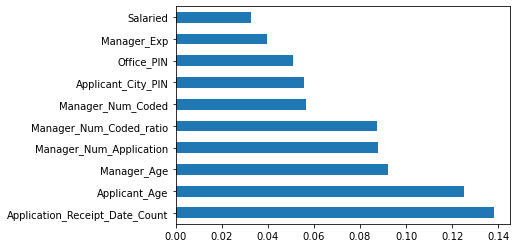

In [77]:
import pandas as pd
import numpy as np

X_5= X.iloc[:,0:40]  #independent columns
y_5 = y.iloc[:,-1]    #target column
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X_5,y_5)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X_5.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [82]:
feat_importances.nlargest(20)

Application_Receipt_Date_Count    0.138315
Applicant_Age                     0.124970
Manager_Age                       0.092171
Manager_Num_Application           0.087765
Manager_Num_Coded_ratio           0.087378
Manager_Num_Coded                 0.056477
Applicant_City_PIN                0.055847
Office_PIN                        0.051122
Manager_Exp                       0.039448
Salaried                          0.032553
M                                 0.026690
Others                            0.022937
Manager_Grade                     0.022473
Level.2                           0.017380
M.1                               0.016891
S                                 0.016581
Missing                           0.015011
Probation                         0.011976
Level.2.1                         0.011804
Level.3.1                         0.009972
dtype: float64

In [97]:
import numpy as np
import pandas as pd 
import os
from sklearn.model_selection import KFold,StratifiedKFold
from lightgbm import LGBMClassifier
import warnings
warnings.filterwarnings('ignore')
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight,compute_sample_weight
from keras.layers import Dense,Dropout
from keras.models import Sequential
from sklearn.preprocessing import StandardScaler
from keras.models import load_model
from keras.models import save_model
from keras.callbacks import ReduceLROnPlateau,ModelCheckpoint
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [98]:
y_hat=to_categorical(y)
y_hat=pd.DataFrame(y_hat)
sc_X=StandardScaler()
X=sc_X.fit_transform(X)
X=pd.DataFrame(X)
sc_X_main=StandardScaler()
X_main_test=sc_X_main.fit_transform(X_main_test)
y.head(5)

,Business_Sourced
0,0
1,1
2,0
3,0
4,0


SyntaxError: invalid syntax (<ipython-input-106-663b054432dd>, line 1)

In [102]:
classifier=Sequential()

classifier.add(Dense(512,activation='relu', kernel_initializer='he_uniform',input_shape=(X_train.shape[1],)))
classifier.add(Dropout(0.2))
classifier.add(Dense(256,activation='relu',kernel_initializer='he_uniform'))
classifier.add(Dense(200,activation='relu',kernel_initializer='he_uniform'))
classifier.add(Dense(128,activation='relu',kernel_initializer='he_uniform'))
classifier.add(Dense(64,activation='relu',kernel_initializer='he_uniform'))
classifier.add(Dense(32,activation='relu',kernel_initializer='he_uniform'))
classifier.add(Dense(2,activation='sigmoid'))

classifier.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
callback_lr=ReduceLROnPlateau(monitor='val_loss',patience=3,factor=0.3,min_lr=0.00001)
callback_mc=ModelCheckpoint(filepath='model_repli.hdf5',monitor='val_accuracy',save_best_only=True,mode='max')
callbacks_list = [callback_lr,callback_mc]

In [103]:
classifier.fit(X_train,y_train,epochs=50,batch_size=32,validation_data=(X_val,y_val),callbacks=[callback_lr])

#classifier=load_model('model_repli.hdf5')
pred_val=classifier.predict(X_val)

preds=classifier.predict(X_main_test)

ValueError: You are passing a target array of shape (7621, 1) while using as loss `categorical_crossentropy`. `categorical_crossentropy` expects targets to be binary matrices (1s and 0s) of shape (samples, classes). If your targets are integer classes, you can convert them to the expected format via:
```
from keras.utils import to_categorical
y_binary = to_categorical(y_int)
```

Alternatively, you can use the loss function `sparse_categorical_crossentropy` instead, which does expect integer targets.

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [3]:
train_df_new = pd.read_csv('train.csv')
test_df_new = pd.read_csv('test.csv')

In [4]:
from fastai.tabular import *

ModuleNotFoundError: No module named 'fastai'

### `LGBM


In [5]:
# Hyperparameter grid
param_grid = {
    'boosting_type': ['gbdt', 'goss', 'dart'],
    'num_leaves': list(range(20, 150)),
    'learning_rate': list(np.logspace(np.log10(0.005), np.log10(0.5), base = 10, num = 1000)),
    'subsample_for_bin': list(range(20000, 300000, 20000)),
    'min_child_samples': list(range(20, 500, 5)),
    'reg_alpha': list(np.linspace(0, 1)),
    'reg_lambda': list(np.linspace(0, 1)),
    'colsample_bytree': list(np.linspace(0.6, 1, 10)),
    'subsample': list(np.linspace(0.5, 1, 100)),
    'is_unbalance': [True, False]
}